In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# ===================== 動態模擬函數 ===================== #
def simulate_deep_scalar_np(N, lambdas, alpha, eta, num_iters):
    """
    dynamics:
        d_{k+1} = d_k - eta * d_k^{N-1} * (d_k^N - lambda)

    參數：
        N         : 深度（整數）
        lambdas   : numpy array, 存放多個 eigenvalues
        alpha     : 初始化 scalar (float)
        eta       : 步長
        num_iters : 迭代次數

    回傳：
        d_hist : shape = (num_iters+1, num_l)，記錄所有迭代軌跡
    """

    lambdas = np.array(lambdas, dtype=float)      # eigenvalues array
    num_l = lambdas.size                          # eigenvalue 個數

    # 初始值 d(0) = α
    d = np.full(num_l, alpha, dtype=float)

    # 記錄所有歷史軌跡
    d_hist = np.zeros((num_iters + 1, num_l))
    d_hist[0] = d

    # 迭代
    for k in range(num_iters):
        d_N   = d ** N         # d^N
        d_Nm1 = d ** (N - 1)   # d^(N-1)

        # 1D dynamics 更新
        d = d - eta * d_Nm1 * (d_N - lambdas)

        d_hist[k + 1] = d

    return d_hist


In [3]:
# ===================== 基本設定 ===================== #

N = 3                          # 深度 N
alpha = 0.1                    # 相同初始化 α > 0
eta = 1e-3                     # 步長 η
num_iters = 10000              # 總迭代次數

# 我們要測試的不同 eigenvalues
lambdas = np.array([10.0, 7.0, 5.0, -5.0], dtype=float)
colors = ["navy", "blue", "deepskyblue", "lightsteelblue"]
linestyles = ["solid", "dashed", "dashed", "solid"]
labels = [r"$\lambda_i = 10$", r"$\lambda_i = 7$", r"$\lambda_i = 5$", r"$\lambda_i = -5$"]

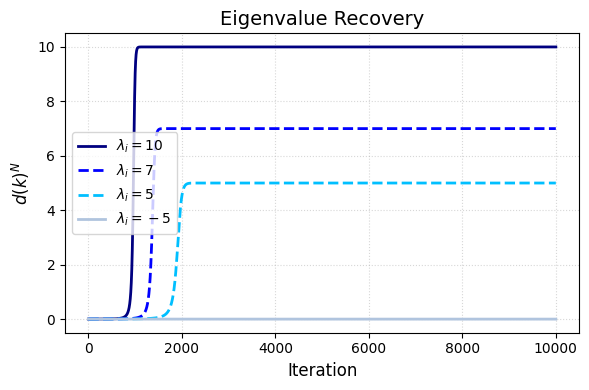

In [4]:
# ===================== 模擬並畫「多個 eigenvalues」圖 ===================== #

d_hist = simulate_deep_scalar_np(N, lambdas, alpha, eta, num_iters)
# d_hist shape = (num_iters+1, num_l)

# d(k)^N = 學到的 eigenvalue
eig_est_hist = d_hist ** N 
iters = np.arange(num_iters + 1)

plt.figure(figsize=(6, 4))

num_l = lambdas.size
for j in range(num_l):
    plt.plot(
        iters,
        eig_est_hist[:, j],
        color=colors[j],
        linestyle=linestyles[j],
        linewidth=2,
        label=labels[j],
    )

plt.title("Eigenvalue Recovery", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel(r"$d(k)^N$", fontsize=12)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()


In [5]:
# ---------------- U^-_N(mu) ---------------- #
def U_minus(N, mu):
    """Compute U_N^-(mu)."""
    N = int(N)
    mu = float(mu)

    if N == 2:
        return -np.log(mu)
    elif N >= 3:
        # 1/(N-2) * mu^{-(N-2)}
        return (1.0 / (N - 2)) * mu ** (-(N - 2))
    else:
        raise ValueError("N must be >= 2")


# ---------------- U^+_N(lambda, mu) ---------------- #
def U_plus(N, lam, mu):
    """Compute U_N^+(lambda, mu)."""
    N = int(N)
    lam = float(lam)
    mu = float(mu)

    if N == 2:
        # U_2^+(λ, μ) = - (1 / (2 λ)) ln( λ/μ^2 − 1 )
        return -(1.0 / (2.0 * lam)) * np.log(lam / (mu**2) - 1.0)

    elif N >= 3:
        # First term:
        # λ^{2/N - 2} / N * sum_{ℓ=1..N} Re( exp(4πiℓ/N) * log( exp(2πiℓ/N) - μ λ^{-1/N} ) )
        term1 = 0.0
        Nf = float(N)
        lam_pow = lam ** (2.0 / Nf - 2.0)
        z = mu * lam ** (-1.0 / Nf)   # μ λ^{-1/N}

        for ell in range(1, N + 1):
            w = np.exp(2j * np.pi * ell / Nf)      # e^{2πiℓ/N}
            v = np.exp(4j * np.pi * ell / Nf)      # e^{4πiℓ/N}
            inside = w - z                         # complex number
            log_inside = np.log(inside)           # complex log
            term1 += np.real(v * log_inside)

        term1 = lam_pow * term1 / Nf

        # Second term: - 1 / ( λ (N-2) μ^{N-2} )
        term2 = -(1.0 / (lam * (N - 2) * mu ** (N - 2)))

        return term1 + term2

    else:
        raise ValueError("N must be >= 2")


# ---------------- T^-_N(μ, α) ---------------- #
def T_minus(N, mu, alpha):
    """
    T_N^{-}(mu, alpha) = U_N^{-}(mu) - U_N^{-}(alpha)
    """
    return U_minus(N, mu) - U_minus(N, alpha)


# ---------------- T^+_N(λ, μ, α) ---------------- #
def T_plus(N, lam, mu, alpha):
    """
    T_N^{+}(lambda, mu, alpha)
    = U_N^{+}(lambda, mu) - U_N^{+}(lambda, alpha)
    """
    return U_plus(N, lam, mu) - U_plus(N, lam, alpha)


# ---------------- c_N, s_N, a_N, b_N ---------------- #
def algebra_constants(N, lam, alpha):
    """
    回傳 (c_N, s_N, a_N, b_N)

    c_N = (N-1)/(2N-1)
    s_N = ceil( c_N^(1 - 1/N) * (λ^(1/N) / α)^(N-1) )
    a_N = | ln(1 - c_N^(1/N)) |
    b_N = | ln(2c_N) - c_N^(1/N) ) |
    """
    N = int(N)
    lam = float(lam)
    alpha = float(alpha)

    # c_N
    c_N = (N - 1.0) / (2.0 * N - 1.0)

    # s_N(λ, α)
    term = c_N**(1 - 1.0 / N) * (lam**(1.0 / N) / alpha)**(N - 1)
    s_N = int(np.ceil(term))

    # a_N
    a_N = abs(np.log(1.0 - c_N**(1.0 / N)))

    # b_N = | ln(1/(2c_N) - c_N^(1/N)) |
    b_N = abs(np.log(2.0 * c_N - c_N**(1.0 / N)))

    return c_N, s_N, a_N, b_N


# ---------------- T_Id_N(λ, ε, α, η, N) ---------------- #
def T_id_N(lam, eps, alpha, eta, N):
    N = int(N)
    lam   = float(lam)
    eps   = float(eps)
    alpha = float(alpha)
    eta   = float(eta)

    m_alpha_eps = max(alpha, eps)
    c_N, s_N, a_N, b_N = algebra_constants(N, lam, alpha)

    def denom_log(lam_val):
        return abs(np.log(1.0 - eta * N * (c_N * lam_val) ** (2.0 - 2.0 / N)))

    # --- Case 1: λ < 0 ----------------------------------------- #
    if lam < 0:
        # 1/(η |λ|) * T_N^-(ε, α)
        return (1.0 / (eta * abs(lam))) * T_minus(N, eps, alpha)

    # --- 後面全部都是 λ >= 0 的情況 ----------------------------- #

    # Case 2: 0 ≤ λ < ε^N
    if 0.0 <= lam < eps ** N:
        return 0.0

    # Case 3: ε^N ≤ λ < α^N
    if eps ** N <= lam < alpha ** N:
        return (1.0 / eta) * T_plus(N, lam, lam ** (1.0 / N) + eps, alpha)

    # Case 4: m_{α,ε}^N ≤ λ < α^N / c_N
    if m_alpha_eps ** N <= lam < (alpha ** N) / c_N:
        num   = np.log((lam ** (1.0 / N) - alpha) / eps)
        denom = denom_log(lam)
        return num / denom

    # 後面是 λ 較大的兩個區間
    # 這裡先用你目前寫的版本：
    # paper 裡你標註的是：(m_{α,ε}^N) / c_N 和 (ε / (1 - c_N^(1 / N)))^N
    lower2 = (m_alpha_eps ** N) / c_N
    upper2 = (eps / (1.0 - c_N** (1.0 / N))) ** N

    # Case 5: (m_{α,ε}^N)/c_N ≤ λ < 上面那個 upper2
    if lower2 <= lam < upper2:
        # μ = λ^{1/N} - ε
        return (1.0 / eta) * T_plus(N, lam, lam ** (1.0 / N) - eps, alpha) + s_N

    # Case 6: 其他情況（otherwise）
    # μ = (c_N λ)^{1/N}，再加上最後那個 log term
    num   = np.log(lam ** (1.0 / N) / eps) - a_N
    denom = denom_log(lam)
    extra = num / denom
    return (1.0 / eta) * T_plus(N, lam, (c_N * lam) ** (1.0 / N), alpha) + s_N + extra

In [6]:
# ===================== 預測收斂迭代次數 ===================== #
# dynamics
d_hist = simulate_deep_scalar_np(N, lambdas, alpha, eta, num_iters)

# 2. d(k)^N 視為學到的 eigenvalue
eig_est_hist = d_hist ** N      # shape = (num_iters+1, num_l)
iters = np.arange(num_iters + 1)
num_l = lambdas.size

# 誤差 ε：希望 |d(k)^N - λ| ≤ ε
eps = 1e-2 # ε越小實際與預測的T相差越多

results = []  # 收集 (lambda, T_pred_cont, T_pred, T_k, rel_error)

for idx in range(num_l):
    lam = lambdas[idx]
    if lam <= 0:
        # 負 eigenvalue 在這篇 paper 的 setting 其實學不起來，就跳過或另做分析
        continue

    eig_est_single = eig_est_hist[:, idx]
    error_single = np.abs(eig_est_single - lam)   # |d(k)^N - λ|

    # 數值上第一次達到誤差 ≤ ε 的 k
    hits = np.where(error_single <= eps)[0]
    if hits.size > 0:
        T_k = int(hits[0])
    else:
        T_k = None  # 沒有在 num_iters 內達標

    # 理論預測迭代次數 T_id_N (連續) + ceil 成整數
    T_pred_cont = T_id_N(lam, eps, alpha, eta, N)
    T_pred = int(np.ceil(T_pred_cont))

    # 相對誤差（如果有 T_k 的話）
    if T_k is not None and T_pred > 0:
        rel_err = (T_k - T_pred) / T_pred
    else:
        rel_err = None

    results.append((lam, T_pred_cont, T_pred, T_k, rel_err))

# 把結果漂亮印出來
print("λ\tT_pred_cont\tT_pred(int)\tT_k(num)\t(relative error)")
for lam, T_pred_cont, T_pred, T_k, rel_err in results:
    if rel_err is None:
        rel_str = "N/A"
    else:
        rel_str = f"{rel_err*100:.2f}%"
    print(f"{lam:.1f}\t{T_pred_cont:10.2f}\t{T_pred:11d}\t{T_k if T_k is not None else -1:9d}\t{rel_str}")


λ	T_pred_cont	T_pred(int)	T_k(num)	(relative error)
10.0	   1383.67	       1384	     1072	-22.54%
7.0	   1830.69	       1831	     1535	-16.17%
5.0	   2463.49	       2464	     2154	-12.58%


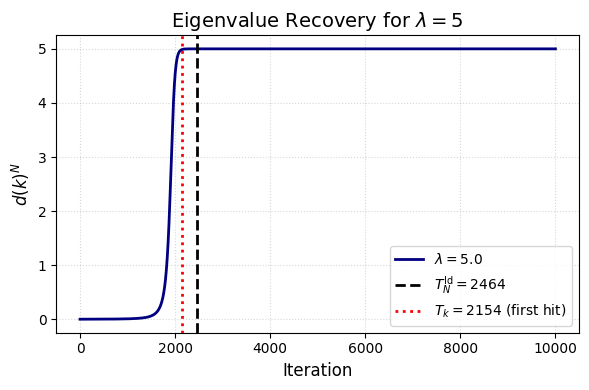

In [7]:
# 選 λ = 5 (idx = 2)
idx = np.where(lambdas == 5.0)[0][0]
lambda_pos = lambdas[idx]

eig_est_single = eig_est_hist[:, idx]
error_single = np.abs(eig_est_single - lambda_pos)

# 重新算一次 T_pred / T_k（也可以從 results 裡抓）
T_pred_cont = T_id_N(lambda_pos, eps, alpha, eta, N)
T_pred = int(np.ceil(T_pred_cont))

hits = np.where(error_single <= eps)[0]
T_k = int(hits[0]) if hits.size > 0 else None

plt.figure(figsize=(6, 4))
plt.plot(
    iters,
    eig_est_single,
    color="navy",
    linewidth=2,
    label=rf"$\lambda = {lambda_pos}$",
)

# 預測的迭代次數（理論 T_pred）
plt.axvline(
    x=T_pred,
    color="black",
    linestyle="--",
    linewidth=2,
    label=rf"$T_N^{{\mathrm{{Id}}}} = {T_pred}$",
)

# 數值實際第一次達到誤差的 T_k
if T_k is not None:
    plt.axvline(
        x=T_k,
        color="red",
        linestyle=":",
        linewidth=2,
        label=rf"$T_k = {T_k}$ (first hit)",
    )

plt.title(r"Eigenvalue Recovery for $\lambda=5$", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel(r"$d(k)^N$", fontsize=12)
plt.legend()
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()


In [8]:
def evaluate_one_setting(N, eps, alpha, eta, lambda_val, num_iters=20000):
    """
    給定一組 (N, eps, alpha, eta, lambda_val)，
    回傳：T_pred, T_k, 相對誤差 rel_err。
    """
    N = int(N)
    eps = float(eps)
    alpha = float(alpha)
    eta = float(eta)
    lam = float(lambda_val)

    # 1. dynamics: 只跑單一 eigenvalue
    d_hist = simulate_deep_scalar_np(N, np.array([lam]), alpha, eta, num_iters)
    eig_est = d_hist[:, 0] ** N   # d(k)^N

    # 2. 數值 T_k：第一次 |d(k)^N - λ| <= eps 的 k
    error = np.abs(eig_est - lam)
    hits = np.where(error <= eps)[0]
    T_k = int(hits[0]) if hits.size > 0 else None

    # 3. 理論 T_pred
    T_pred_cont = T_id_N(lam, eps, alpha, eta, N)
    T_pred = int(np.ceil(T_pred_cont))

    # 4. 相對誤差
    if T_k is not None and T_pred > 0:
        rel_err = (T_k - T_pred) / T_pred
    else:
        rel_err = None

    return T_pred, T_k, rel_err


In [9]:
def print_sweep_lambdas(N, eps, alpha, eta, lambda_list, num_iters=20000):
    print("\n=== Sweep over eigenvalues λ (fixed N, eps, alpha, eta) ===")
    print(f"N = {N}, eps = {eps}, alpha = {alpha}, eta = {eta}")
    print("λ\tT_pred\tT_k\trelative error")
    print("----------------------------------------")

    for lam in lambda_list:
        if lam <= 0:
            # 這裡你可以選擇要不要列出負 λ；先跳過也可以
            print(f"{lam:.2f}\t   -   \t   -   \tN/A (λ<=0)")
            continue

        T_pred, T_k, rel_err = evaluate_one_setting(N, eps, alpha, eta, lam, num_iters)

        rel_str = "N/A" if rel_err is None else f"{rel_err*100:.2f}%"
        print(f"{lam:.2f}\t{T_pred:6d}\t{T_k if T_k is not None else -1:6d}\t{rel_str}")


In [10]:
lambda_list = [50.0, 20.0, 10.0, 7.0, 5.0, 3.0]
print_sweep_lambdas(N=3, eps=1e-2, alpha=0.1, eta=1e-3, lambda_list=lambda_list)



=== Sweep over eigenvalues λ (fixed N, eps, alpha, eta) ===
N = 3, eps = 0.01, alpha = 0.1, eta = 0.001
λ	T_pred	T_k	relative error
----------------------------------------
50.00	   954	   211	-77.88%
20.00	   956	   533	-44.25%
10.00	  1384	  1072	-22.54%
7.00	  1831	  1535	-16.17%
5.00	  2464	  2154	-12.58%
3.00	  4006	  3598	-10.18%


In [11]:
def print_sweep_N(N_list, eps, alpha, eta, lambda_val, num_iters=20000):
    print("\n=== Sweep over depth N (fixed λ, eps, alpha, eta) ===")
    print(f"λ = {lambda_val}, eps = {eps}, alpha = {alpha}, eta = {eta}")
    print("N\tT_pred\tT_k\trelative error")
    print("----------------------------------------")

    for N in N_list:
        T_pred, T_k, rel_err = evaluate_one_setting(N, eps, alpha, eta, lambda_val, num_iters)
        rel_str = "N/A" if rel_err is None else f"{rel_err*100:.2f}%"
        print(f"{N:2d}\t{T_pred:6d}\t{T_k if T_k is not None else -1:6d}\t{rel_str}")


In [13]:
print_sweep_N(N_list=[2, 3, 4, 5], eps=1e-2, alpha=0.1, eta=1e-3, lambda_val=5.0)


=== Sweep over depth N (fixed λ, eps, alpha, eta) ===
λ = 5.0, eps = 0.01, alpha = 0.1, eta = 0.001
N	T_pred	T_k	relative error
----------------------------------------
 2	  1928	  1241	-35.63%
 3	  2464	  2154	-12.58%
 4	 11935	 10126	-15.16%
 5	 85704	    -1	N/A


In [14]:
def print_sweep_eps(N, eps_list, alpha, eta, lambda_val, num_iters=20000):
    print("\n=== Sweep over eps (fixed N, λ, alpha, eta) ===")
    print(f"N = {N}, λ = {lambda_val}, alpha = {alpha}, eta = {eta}")
    print("eps\tT_pred\tT_k\trelative error")
    print("----------------------------------------")

    for eps in eps_list:
        T_pred, T_k, rel_err = evaluate_one_setting(N, eps, alpha, eta, lambda_val, num_iters)
        rel_str = "N/A" if rel_err is None else f"{rel_err*100:.2f}%"
        print(f"{eps:.1e}\t{T_pred:6d}\t{T_k if T_k is not None else -1:6d}\t{rel_str}")


In [15]:
print_sweep_eps(N=3, eps_list=[1e-1, 1e-2, 1e-3], alpha=0.1, eta=1e-3, lambda_val=5.0)


=== Sweep over eps (fixed N, λ, alpha, eta) ===
N = 3, λ = 5.0, alpha = 0.1, eta = 0.001
eps	T_pred	T_k	relative error
----------------------------------------
1.0e-01	  2161	  2065	-4.44%
1.0e-02	  2464	  2154	-12.58%
1.0e-03	  2767	  2243	-18.94%


In [16]:
def print_sweep_alpha(N, eps, alpha_list, eta, lambda_val, num_iters=20000):
    print("\n=== Sweep over alpha (fixed N, λ, eps, eta) ===")
    print(f"N = {N}, λ = {lambda_val}, eps = {eps}, eta = {eta}")
    print("alpha\tT_pred\tT_k\trelative error")
    print("----------------------------------------")

    for alpha in alpha_list:
        T_pred, T_k, rel_err = evaluate_one_setting(N, eps, alpha, eta, lambda_val, num_iters)
        rel_str = "N/A" if rel_err is None else f"{rel_err*100:.2f}%"
        print(f"{alpha:.3f}\t{T_pred:6d}\t{T_k if T_k is not None else -1:6d}\t{rel_str}")


In [17]:
print_sweep_alpha(N=3, eps=1e-2, alpha_list=[0.05, 0.1, 0.2], eta=1e-3, lambda_val=5.0)


=== Sweep over alpha (fixed N, λ, eps, eta) ===
N = 3, λ = 5.0, eps = 0.01, eta = 0.001
alpha	T_pred	T_k	relative error
----------------------------------------
0.050	  4940	  4155	-15.89%
0.100	  2464	  2154	-12.58%
0.200	  1346	  1153	-14.34%


In [18]:
def print_sweep_eta(N, eps, alpha, eta_list, lambda_val, num_iters=20000):
    print("\n=== Sweep over eta (fixed N, λ, eps, alpha) ===")
    print(f"N = {N}, λ = {lambda_val}, eps = {eps}, alpha = {alpha}")
    print("eta\tT_pred\tT_k\trelative error")
    print("----------------------------------------")

    for eta in eta_list:
        T_pred, T_k, rel_err = evaluate_one_setting(N, eps, alpha, eta, lambda_val, num_iters)
        rel_str = "N/A" if rel_err is None else f"{rel_err*100:.2f}%"
        print(f"{eta:.1e}\t{T_pred:6d}\t{T_k if T_k is not None else -1:6d}\t{rel_str}")


In [19]:
print_sweep_eta(N=3, eps=1e-2, alpha=0.1, eta_list=[1e-2, 1e-3, 5e-4], lambda_val=5.0)


=== Sweep over eta (fixed N, λ, eps, alpha) ===
N = 3, λ = 5.0, eps = 0.01, alpha = 0.1
eta	T_pred	T_k	relative error
----------------------------------------
1.0e-02	   388	   216	-44.33%
1.0e-03	  2464	  2154	-12.58%
5.0e-04	  4770	  4308	-9.69%
